#Hands-on Activity 5.1 Generating Images with GANs and VAEs

#Procedures and Discussion: Variational Autoencoders and GANs

In [2]:
!pip install imgaug

   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   --------------------- ----------------- 512.0/948.0 kB 16.2 MB/s eta 0:00:01
   --------------------------------------- 948.0/948.0 kB 20.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   - -------------------------------------- 1.0/24.5 MB 20.5 MB/s eta 0:00:02
   --- ------------------------------------ 2.1/24.5 MB 22.1 MB/s eta 0:00:02
   ----- ---------------------------------- 3.4/24.5 MB 24.2 MB/s eta 0:00:01
   ------- -------------------------------- 4.7/24.5 MB 24.8 MB/s eta 0:00:01
   --------- ------------------------------ 5.8/24.5 MB 24.6 MB/s eta 0:00:01
   ----------- ---------------------------- 6.9/24.5 MB 24.5 MB/s eta 0:00:01
   ------------- -------------------------- 8.2/24.5 MB 24.9 MB/s eta 0:00:01
   --------------- ------------------------ 9.6/24.5 MB 25.5 MB/s eta 0:00:01
   ----------------- ---------------------- 10.8/24.5 MB 26.2 MB/s eta 0:00

In [3]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
#

from keras.layers import *
from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#

print(tf.__version__)

2.10.1


## Part 1: Autoencoders (AEs)

Answer: What is the typical architecture of a 'vanilla/standard/traditional' autoencoder.

- The standard structure of autoencoder starts with encoder, encoder minimizes the dimensionality of the input data and will extract the most important features, the output of encoder will converted to tensor values (latent feature representation) and this will be passed to the trained decoder neural network which uses the outout values of encoder to reconstruct data with less features compared to original one.

### Data: Acquisition and Pre-processing
We will be using Fashion-MNIST, which can be conveniently accessed with Keras.

4431872/4422102 [==============================] - 1s 0us/step
X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


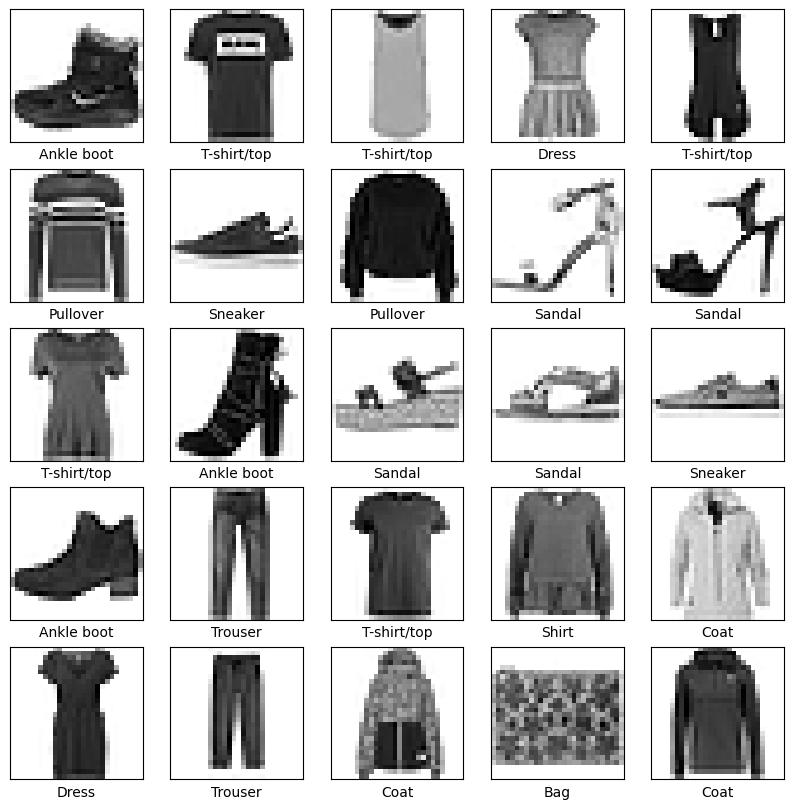

In [5]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display the first 25 garments from the training set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### Add Noise to the Images

In attempt to make the autoencoder more robust and not just memorize the inputs, let's add noise to the inputs but calculate its loss based on how similar its outputs are to the original (non-denoised) images.

Check out imgaug docs for more info and other ways to add noise.

In [6]:
# Neural Networks want the inputs to be 3D
n_samples, h, w = X_train.shape

X_train = X_train.reshape(-1, h, w, 1)
X_test = X_test.reshape(-1, h, w, 1)

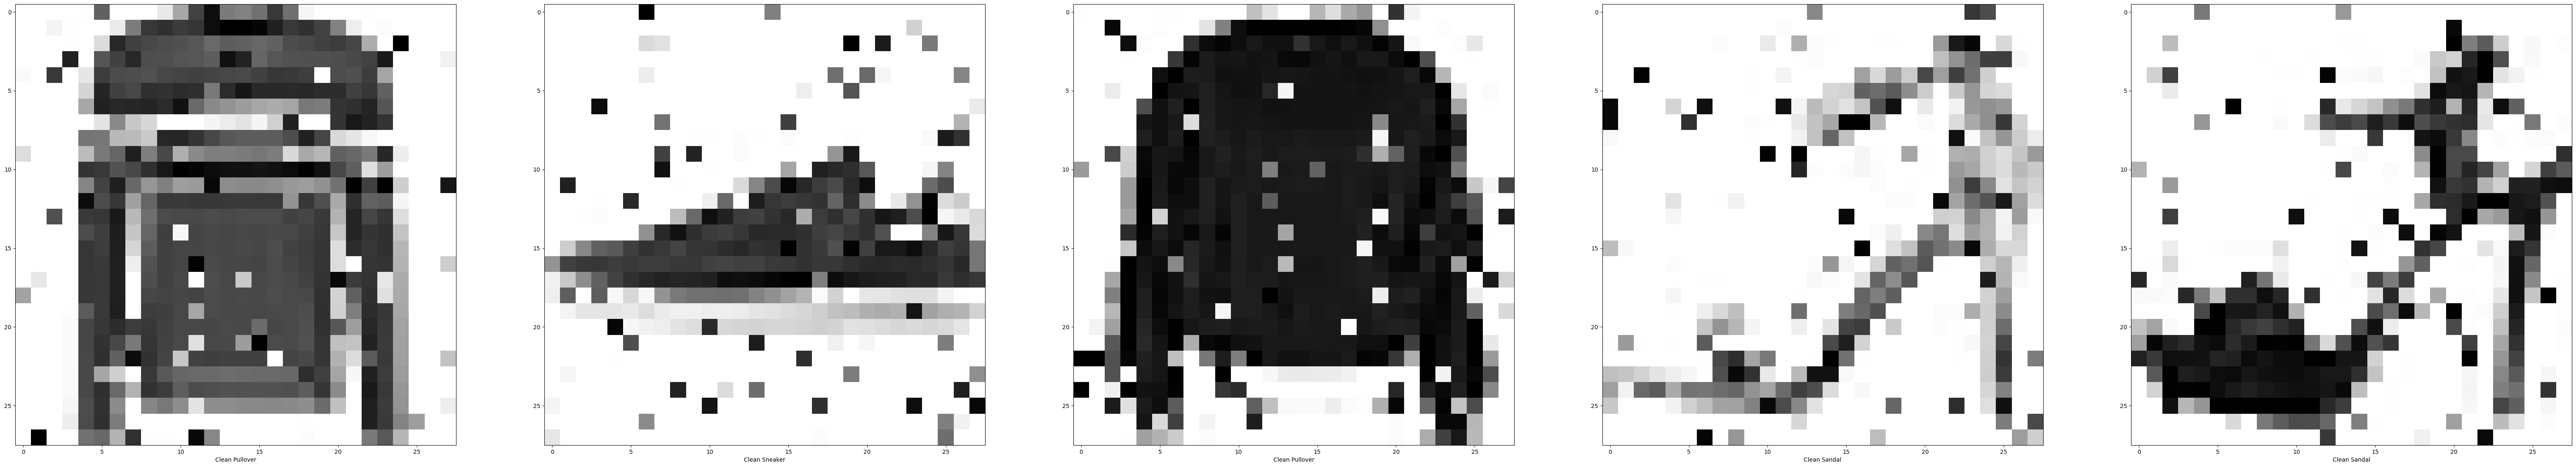

In [7]:
# Adding some 'salt and pepper' noises
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(X_train_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[y_train[i]])

#### Create the Autoencoder

In [8]:
# input layer
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = tf.keras.layers.Conv2D(64,(3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = tf.keras.layers.Conv2D(16,(3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer3)
output_layer = tf.keras.layers.Conv2D(1,(3, 3), padding='same')(decoded_layer3)

# compile the model
model = tf.keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

#### Train the Autoencoder

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=5, mode='auto')

# epochs=20 for better results
history = model.fit(X_train_n, X_train, epochs=25, batch_size=2048, validation_data=(X_test_n, X_test), callbacks=[early_stopping])

Epoch 1/25
30/30 [==============================] - 268s 9s/step - loss: 0.0785 - val_loss: 0.0431
Epoch 2/25
30/30 [==============================] - 315s 11s/step - loss: 0.0367 - val_loss: 0.0323
Epoch 3/25
 3/30 [==>...........................] - ETA: 4:48 - loss: 0.0322

In [ ]:
n = np.random.randint(0,len(X_test)-5) # pick a random starting index within our test set

#### Visualize Samples reconstructed by AE

**Denoised Images**

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

**Actual Targets (i.e., Original inputs)**

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)): # display the 5 images starting at our random index
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

**Predicted Images**

In [ ]:
preds = model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

## Part 2: Variational Autoencoders (VAEs)

**Discussion: Why do we care to use VAEs? Identify the limitations/weaknesses of Autoencoders**

- One of the most common disadvantages or limitations in using autoencoders are, when the data used in training autoencoders is not enough, instead of extracting the data properly, it may obscure the information due to low performance of encoder. It can also remove any interpretability for your model since it only captures the most important features of the data.

### Reset Data

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

### Setup Encoder Neural Network

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = tf.keras.layers.Input(shape=(784,), name="input")
x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = tf.keras.layers.Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = tf.keras.layers.Input((2,), name="input_decoder")

x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = tf.keras.layers.Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [ ]:
decoder.summary()

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
z_decoded

In [ ]:
# VAE model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

In [ ]:
X_train.shape

In [ ]:
train_x = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
val_x = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(val_x, None))

1/1 [==============================] - 0s 16ms/step


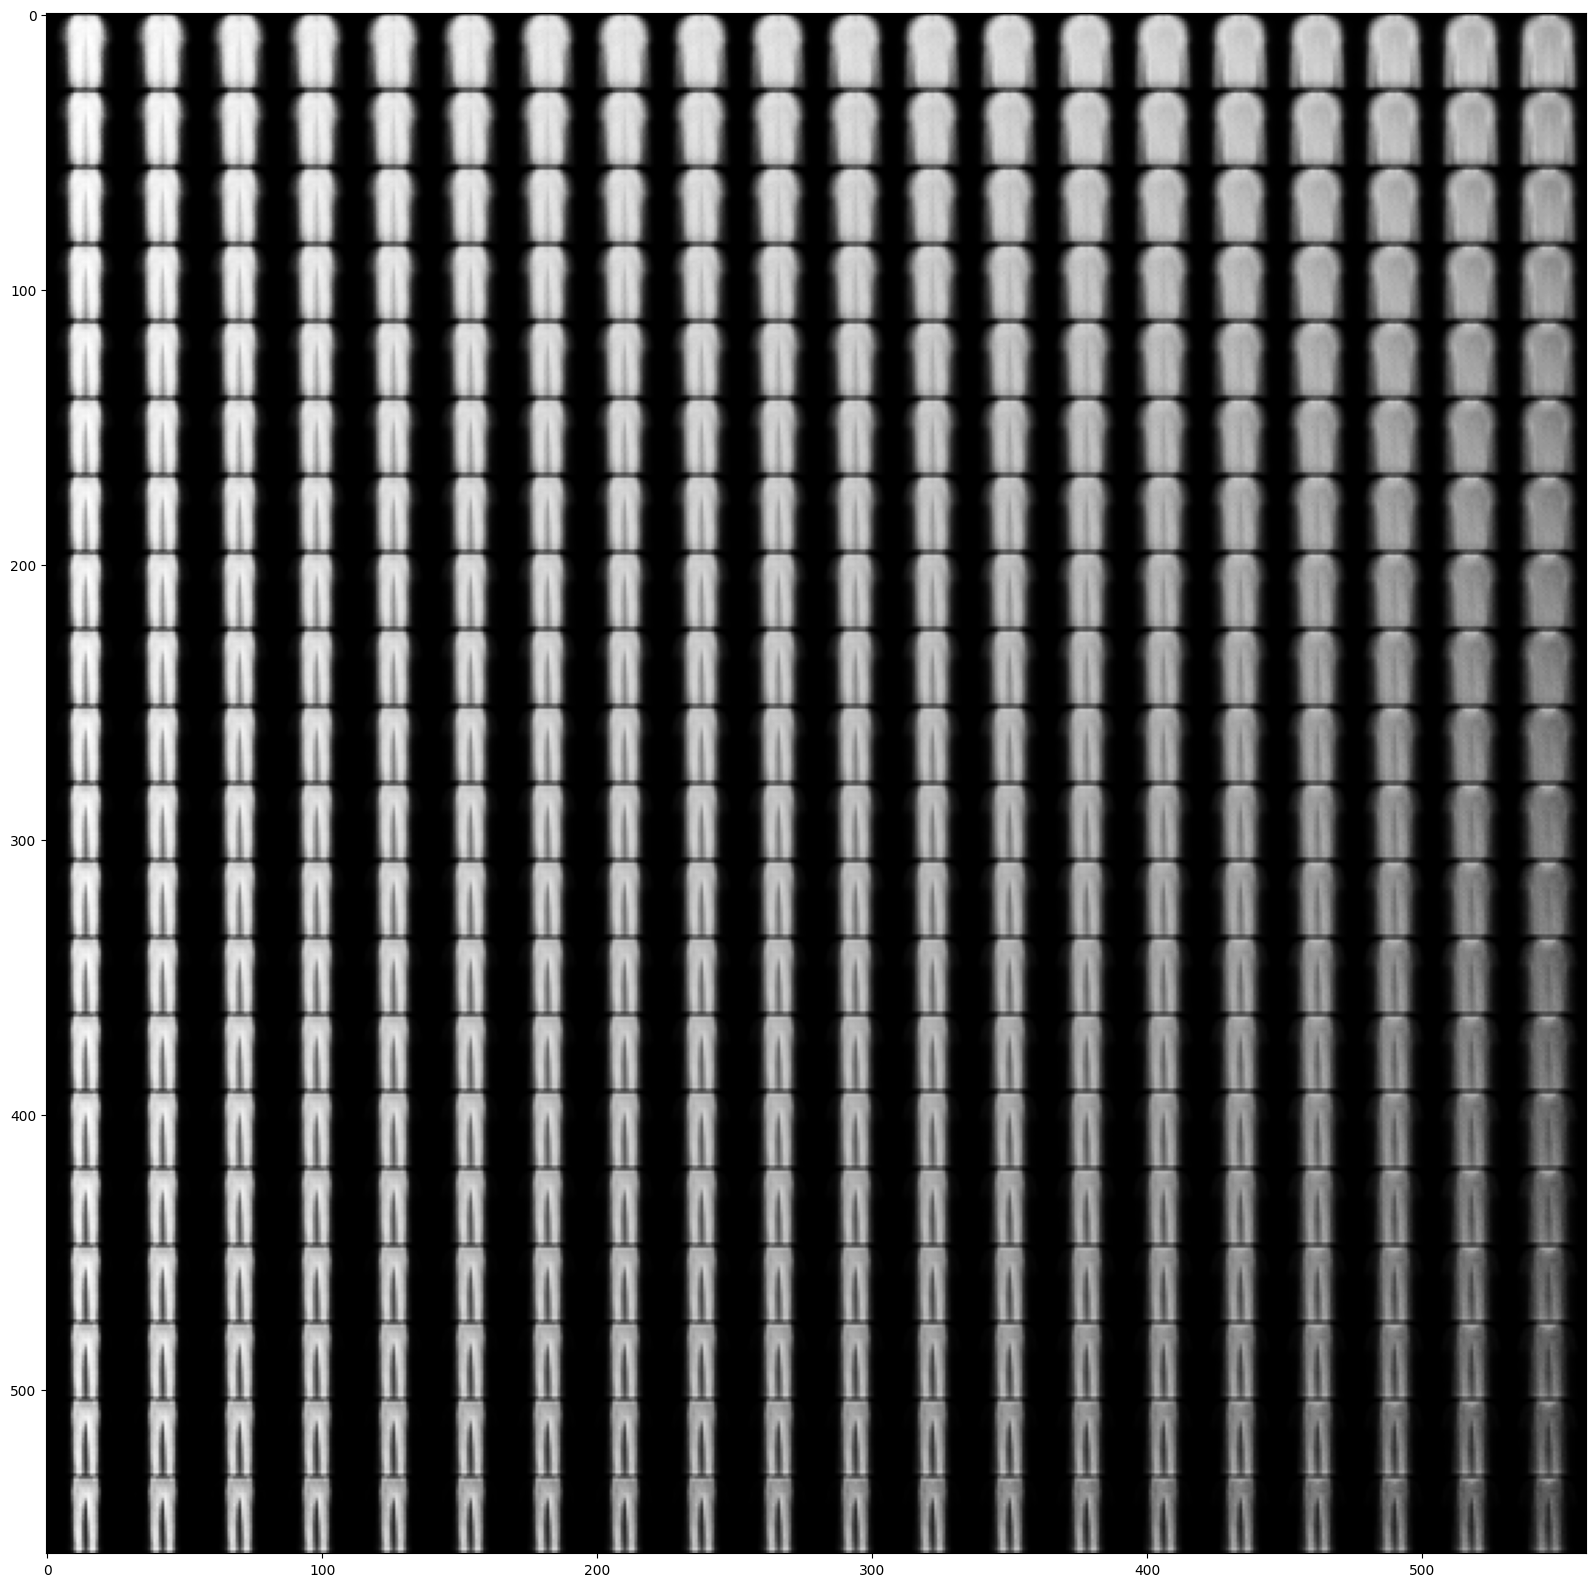

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

3750/3750 [==============================] - 6s 2ms/step


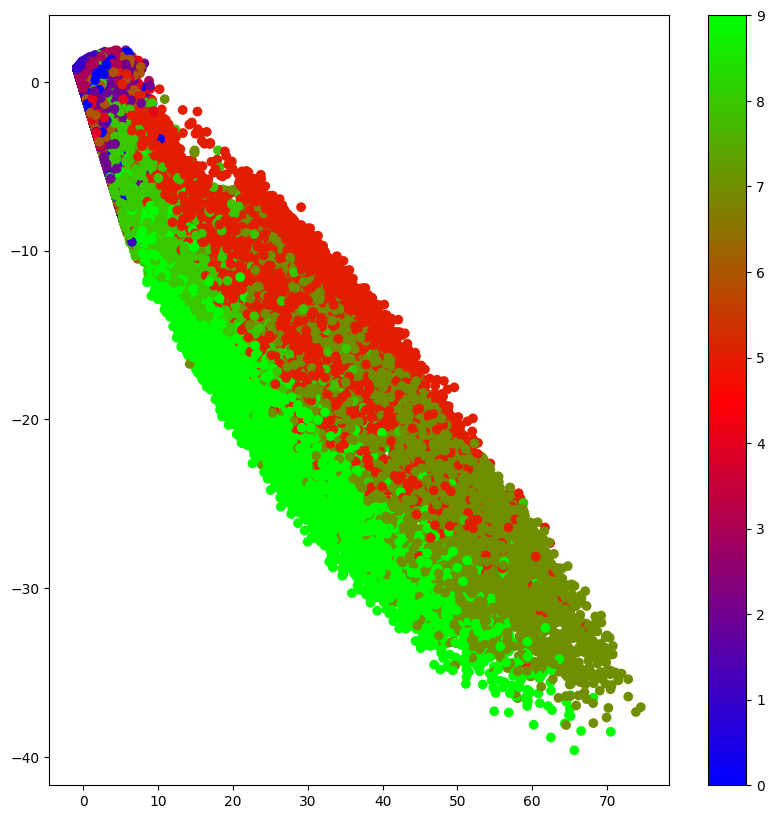

In [ ]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu) # works on older version of TF and Keras
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Part 2B: Adding CNNs and KL Divergence Losses

### Generating new fashion

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32,3,padding='same', activation='relu')(input_img)
x = Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Setup Sampling Function

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network
Task: Try different number of hidden layers and nodes?

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Setup Loss Function

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

In [ ]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

### Visualize Samples Reconstructed by VAE

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

### VAE: Visualize Latent Space

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Exercise: Generating a 1D Gaussian Distribution from Uniform Noise

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

Generate training data - Gaussian Distribution

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

A general function to define feedforward architectures

In [ ]:
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',optimizer='adam', loss = 'binary_crossentropy'):
  model = Sequential()
  model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))

  for _ in range(n_layers-1):
    model.add(Dense(hidden_dim),activation=activation)
  model.add(Dense(output_dim))

  model.compile(loss=loss, optimizer=optimizer)
  print(model.summary())
  return model

Setting GAN training and losses here

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [ ]:
# hyper-parameters
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
    batch_count = x_train.shape[0]/batch_size

    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for e in range(1,epochs+1):

        # generate noise from a uniform distribution
        noise = np.random.rand(batch_size,NOISE_DIM)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

        generated_values = generator.predict(noise)
        X = np.concatenate([generated_values,true_batch])

        y_dis = np.zeros(2*batch_size)

        #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
        #the generator may just produce these features only to exploit the discriminator.
        #The optimization may turn too greedy and produces no long term benefit.
        #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
        y_dis[:batch_size] = 0.9

        discriminator.trainable = True
        disc_history = discriminator.train_on_batch(X, y_dis)
        discriminator.trainable = False

        # Train generator
        noise = np.random.rand(batch_size,NOISE_DIM)
        y_gen = np.zeros(batch_size)
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

**CONCLUSION**

Some conclusions we can make from this exercise:
1. GANs are able to learn a generative model from general noise distributions.
2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)


# Supplementary Activities

## Part 1: MNIST GAN - Learn to Generate MNIST Digits

In [5]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Re-scale data since we are using ReLU activations. **WHY?**

In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Set noise dimension

**EXERCISE : Play around with different noise dimensions and plot the performance with respect to the size of the noise vector.**

In [7]:
z_dim = 100

Tasks:
1. Build Model using LeakyReLU Activations: Build a generator, discriminator, and a GAN as feed-forward network with multiple layers, dropout, and leakyReLU as activation function.
2. Train Model
3. Provide an evaluation/conclusion.

In [14]:
def build_generator(input_shape=(28,28,1),n_classes=10):
    label_input = Input(shape=(1,))
    #Embedding layer
    em = Embedding(n_classes,50)(label_input)
    nodes = 7*7
    
    em = Dense(nodes)(em)
    em = Reshape((7,7,1))(em)
    #image generator input
    image_input = Input(shape=(latent_dim,))
    nodes = 128*7*7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = Reshape((7,7,128))(d1)
    # merge
    merge = Concatenate()([d1,em])
    #upsample to 14x14
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    #upsample to 28x28
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    #output layer 
    out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
    #define model 
    model = Model([image_input,label_input],out_layer)
    return model

In [11]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [15]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
  # make the discriminator layer as non trainable
  d_model.trainable = False
  # get the noise and label input from the generator
  gen_noise, gen_label = g_model.input
  # get the output from the generator
  gen_output = g_model.output
  #connect image output and label input from generator as inputs to      #discriminator
  gan_output = d_model([gen_output,gen_label])
  #define gan model as taking noise and label and outputting a #classification
  model = Model([gen_noise,gen_label],gan_output)
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [12]:
# create model
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

## Part 2: GANs and VAEs

Tasks:
1. Use your own dataset.
2. Generate new images using GAN and VAE
3. Compare the results of generating images using GAN and VAE.

In [ ]:
def build_generator(input_shape=(28,28,1),n_classes=10):
    label_input = Input(shape=(1,))
    #Embedding layer
    em = Embedding(n_classes,50)(label_input)
    nodes = 7*7
    
    em = Dense(nodes)(em)
    em = Reshape((7,7,1))(em)
    #image generator input
    image_input = Input(shape=(latent_dim,))
    nodes = 128*7*7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = Reshape((7,7,128))(d1)
    # merge
    merge = Concatenate()([d1,em])
    #upsample to 14x14
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    #upsample to 28x28
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    #output layer 
    out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
    #define model 
    model = Model([image_input,label_input],out_layer)
    return model

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
  # make the discriminator layer as non trainable
  d_model.trainable = False
  # get the noise and label input from the generator
  gen_noise, gen_label = g_model.input
  # get the output from the generator
  gen_output = g_model.output
  #connect image output and label input from generator as inputs to      #discriminator
  gan_output = d_model([gen_output,gen_label])
  #define gan model as taking noise and label and outputting a #classification
  model = Model([gen_noise,gen_label],gan_output)
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
# create model
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

## Conclusion: Using GANS

In [ ]:
def build_generator(input_shape=(28,28,1),n_classes=10):
    label_input = Input(shape=(1,))
    #Embedding layer
    em = Embedding(n_classes,50)(label_input)
    nodes = 7*7
    
    em = Dense(nodes)(em)
    em = Reshape((7,7,1))(em)
    #image generator input
    image_input = Input(shape=(latent_dim,))
    nodes = 128*7*7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = Reshape((7,7,128))(d1)
    # merge
    merge = Concatenate()([d1,em])
    #upsample to 14x14
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    #upsample to 28x28
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    #output layer 
    out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
    #define model 
    model = Model([image_input,label_input],out_layer)
    return model

In [ ]:
def build_generator(input_shape=(28,28,1),n_classes=10):
    label_input = Input(shape=(1,))
    #Embedding layer
    em = Embedding(n_classes,50)(label_input)
    nodes = 7*7
    
    em = Dense(nodes)(em)
    em = Reshape((7,7,1))(em)
    #image generator input
    image_input = Input(shape=(latent_dim,))
    nodes = 128*7*7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = Reshape((7,7,128))(d1)
    # merge
    merge = Concatenate()([d1,em])
    #upsample to 14x14
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    #upsample to 28x28
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    #output layer 
    out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
    #define model 
    model = Model([image_input,label_input],out_layer)
    return model

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
  # make the discriminator layer as non trainable
  d_model.trainable = False
  # get the noise and label input from the generator
  gen_noise, gen_label = g_model.input
  # get the output from the generator
  gen_output = g_model.output
  #connect image output and label input from generator as inputs to      #discriminator
  gan_output = d_model([gen_output,gen_label])
  #define gan model as taking noise and label and outputting a #classification
  model = Model([gen_noise,gen_label],gan_output)
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
# create model
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
  # make the discriminator layer as non trainable
  d_model.trainable = False
  # get the noise and label input from the generator
  gen_noise, gen_label = g_model.input
  # get the output from the generator
  gen_output = g_model.output
  #connect image output and label input from generator as inputs to      #discriminator
  gan_output = d_model([gen_output,gen_label])
  #define gan model as taking noise and label and outputting a #classification
  model = Model([gen_noise,gen_label],gan_output)
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
# create model
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

## Conclusion : 
- Using GAN and VAE has its own advantages and disadvantages. Generative modeling is applicable when you want to perform unsupervised learning, as it often generalizes better since it learns the data by reconstructing the input data and uses reconstruction error as a metric in comparing the performance of generated data to input data. In conclusion, these topic is hard because we are trying to estimate unknown probability density without labels because generative modeling is mostly unsupervised learning. Building the model by scratch is hard since this requires more parameters in able to work. Generative models need to capture more complex relationships and dependancies in the data, since we want the model to reconstruct the input data.

# References


> **Variational Autoencoders and GANs**
>
> Harvard University
>
> Fall 2020
>
> Instructors: Mark Glickman, Pavlos Protopapas, and Chris Tanner
>
> Lab Instructors: Chris Tanner and Eleni Angelaki Kaxiras
>
> Content: Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner
>
> Link: https://harvard-iacs.github.io/2020-CS109B/labs/lab10/notebook/

